In [1]:
%load_ext autoreload
%autoreload 2

Here we train a very simple Harmonic Oscillator systems in the constant total energy setting.

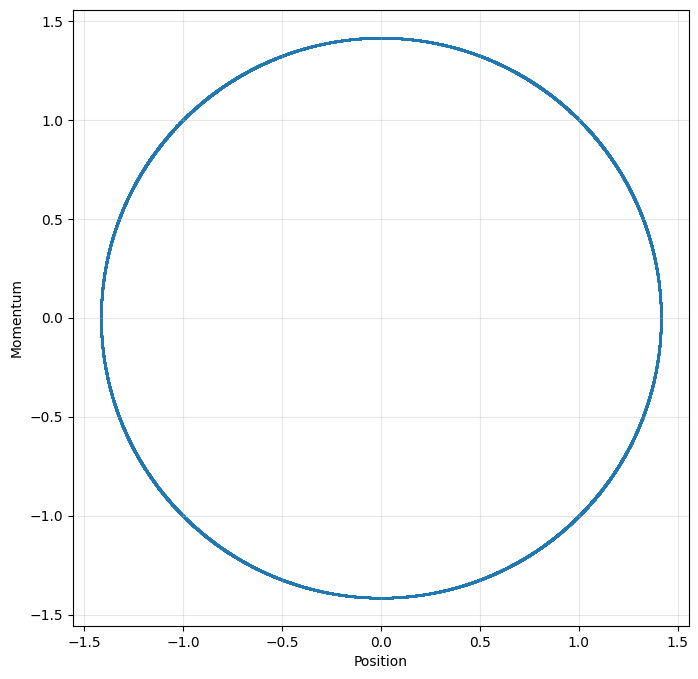

Shapes: (30000, 1, 1) (30000, 1, 1) (30000, 1, 1) (30000, 1)


In [6]:
# Here we generate the reference data
# During training, we use only decorrelated samples

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from hfm.potentials.toy_potentials import HarmonicPotential

rng_phi = jax.random.PRNGKey(42)
n_samples = 30_000
total_energy = 1.0
xrange = jnp.sqrt(2*total_energy)

# Randomly sample phase space - no trajectory information is needed
phi = jax.random.uniform(rng_phi, (n_samples, 1), minval=0, maxval=2*jnp.pi)
xs = jnp.sqrt(2*total_energy) * jnp.cos(phi)
ps = - jnp.sqrt(2*total_energy) * jnp.sin(phi)

# Visualize generated data
plt.figure(figsize=(10, 8))
plt.scatter(xs.flatten(), ps.flatten(), s=1, alpha=0.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('Position')
plt.ylabel('Momentum')
plt.grid(True, alpha=0.3)
plt.show()

# Save data to numpy
# Here we also store momenta to accelerate convergence
# We could also just sample momenta randomly during training
momenta = ps.reshape(-1, 1, 1)
positions = xs.reshape(-1, 1, 1)

vfm = HarmonicPotential()

forces = -positions
epot = vfm.compute_epot(positions)

print("Shapes:", positions.shape, momenta.shape, forces.shape, epot.shape)
np.savez("ho_data.npz", R=positions, momenta=momenta, F=forces, masses=vfm.masses, E=epot, z=jnp.array([1.0]))

dict_keys(['atomic_numbers', 'f', 'masses', 'p', 'v', 'x'])
Pos shape: (501, 1), Forces shape: (501, 1), Momenta shape: (501, 1), Velocities shape: (501, 1)


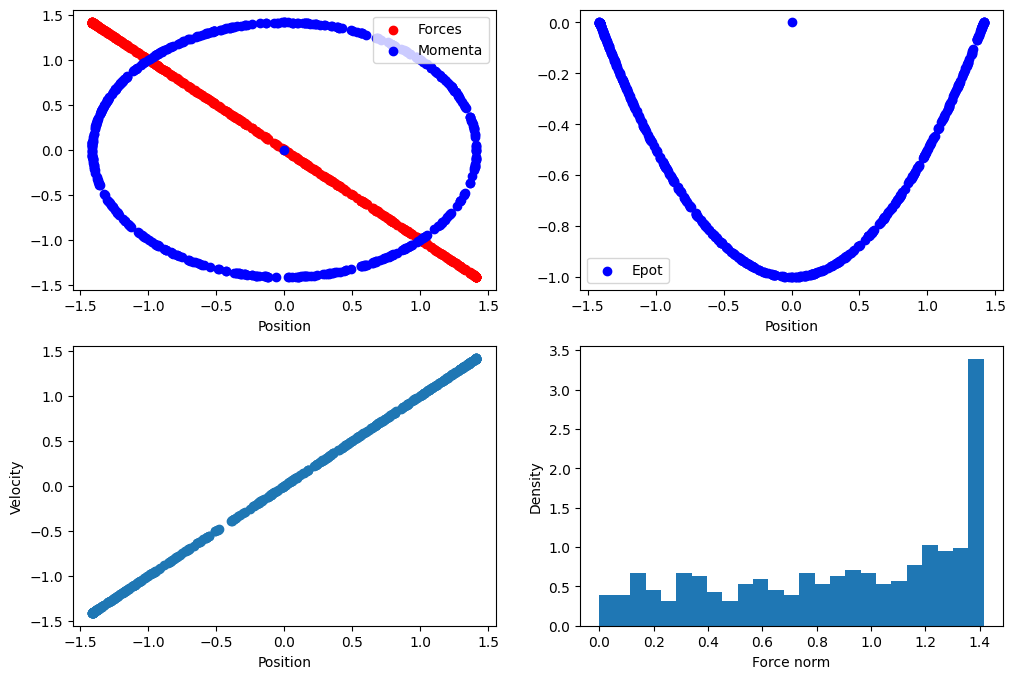

In [7]:
# Visualize a single batch

from hfm.datasets.numpy_datamodule import NumpyDataModule
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from hfm.datasets.hfm_dataset import HFMDataset

data_module = NumpyDataModule("ho_data.npz", force_unit=1, energy_unit=1, pos_unit=1, load_momenta=True, get_masses_from_ase=False, center_pos=False)
dataset = data_module.train_dataset
dataset = HFMDataset(dataset, temperature_mean=0, n_dim=1, rotation_augmentation=False, load_momenta_from_force_dataset=True, zero_drift=False)

rng = jax.random.PRNGKey(42)

for batch in dataset.next_epoch(rng, batch_size=500):
    print(batch.nodes.keys())
    positions = batch.nodes["x"]
    forces = batch.nodes["f"]
    p = batch.nodes["p"]
    v = batch.nodes["v"]
    epot = batch.globals["Epot"]

    large_force_threshold = 3000
    force_norm = jnp.linalg.norm(forces, axis=-1, keepdims=True)  # (batch_size, num_nodes)
    forces = jnp.where(force_norm < large_force_threshold, forces, large_force_threshold * (forces / force_norm))

    print(f"Pos shape: {positions.shape}, Forces shape: {forces.shape}, Momenta shape: {p.shape}, Velocities shape: {v.shape}")
    
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.scatter(positions, forces, color="red", label="Forces")
    plt.scatter(positions, p, color="blue", label="Momenta")
    plt.xlabel("Position")
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.scatter(positions, epot, color="blue", label="Epot")
    plt.xlabel("Position")
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.scatter(p, v)
    plt.xlabel("Position")
    plt.ylabel("Velocity")

    plt.subplot(2, 2, 4)
    data = jnp.linalg.norm(forces, axis=-1)
    plt.hist(data, bins=25, density=True)
    plt.ylabel("Density")
    plt.xlabel("Force norm")

    break

In [8]:
# train a hfm
# with direct force / velocity, energy prediction

from hfm.backbones.mlp import MLPBackbone
from hfm.training.trainer import HFMTrainer
import pickle

model_kwargs = {
    'predict_grad_pot': False,
    'dropout_rate': 0.0,
}
model = MLPBackbone(**model_kwargs)

scale_parameters = {
    "mean_force": 1.0,
    "mean_velocity": 1.0,
    "energy": 1.0,
    "position": 1.0,
    "momentum": 1.0,
}

trainer = HFMTrainer(data_module=data_module, 
                      temperature_mean=0.0,  # will be ignored
                      temperature_std=0.0,  # will be ignored
                      n_dim=1,
                      rotation_augmentation=False,
                      zero_momenta_p=False,
                      zero_t_p=0.75, 
                      t_max=10.0,
                      model=model,
                      scale_parameters=scale_parameters, 
                      validate_after_n_epochs=20,
                      n_epochs=200,
                      load_momenta_from_force_dataset=True, # for simplicity we draw momenta from dataset
                      save_params_every=100000,
                      zero_drift=False,
                      )
params = trainer(verbose=False)

with open("params_ho.pkl", "wb") as f:
    pickle.dump(params, f)

Initializing model...
Number of params: 627523
Starting training...


Epoch 0, Validation summary: {'val/loss': np.float64(1.3428030014038086), 'val/L2 train loss': np.float64(5.91034164428711), 'val/energy loss (L2)': np.float64(0.009455398470163346), 'val/energy loss (adaptive)': np.float64(0.07397915869951248), 'val/energy loss MAE': np.float64(0.07981466352939606), 'val/force loss (t=0) MAE': np.float64(0.09644302874803543), 'val/force loss (t>0) MAE': np.float64(0.15349842011928558), 'val/mean force loss (L2)': np.float64(2.300250220298767), 'val/mean force loss (adaptive)': np.float64(0.5416624426841736), 'val/mean velocity loss (L2)': np.float64(3.6006359100341796), 'val/mean velocity loss (adaptive)': np.float64(0.7271613717079163), 'val/velocity loss (t=0) MAE': np.float64(0.12049809545278549), 'val/velocity loss (t>0) MAE': np.float64(0.13998999297618867)}


Epoch 20, Validation summary: {'val/loss': np.float64(1.2538789987564087), 'val/L2 train loss': np.float64(6.519854927062989), 'val/energy loss (L2)': np.float64(6.557651868206449e-05), 'val/energy loss (adaptive)': np.float64(0.0017261513974517583), 'val/energy loss MAE': np.float64(0.005799334682524204), 'val/force loss (t=0) MAE': np.float64(0.005351765919476748), 'val/force loss (t>0) MAE': np.float64(0.7316208243370056), 'val/mean force loss (L2)': np.float64(3.8450713634490965), 'val/mean force loss (adaptive)': np.float64(0.6709191918373107), 'val/mean velocity loss (L2)': np.float64(2.6747177600860597), 'val/mean velocity loss (adaptive)': np.float64(0.5812336325645446), 'val/velocity loss (t=0) MAE': np.float64(0.003586612641811371), 'val/velocity loss (t>0) MAE': np.float64(0.782956862449646)}


Epoch 40, Validation summary: {'val/loss': np.float64(0.8305254817008972), 'val/L2 train loss': np.float64(2.6573907852172853), 'val/energy loss (L2)': np.float64(6.412739894585684e-05), 'val/energy loss (adaptive)': np.float64(0.0016507066786289216), 'val/energy loss MAE': np.float64(0.005328400805592537), 'val/force loss (t=0) MAE': np.float64(0.013056495971977711), 'val/force loss (t>0) MAE': np.float64(0.8275338768959045), 'val/mean force loss (L2)': np.float64(1.2002790689468383), 'val/mean force loss (adaptive)': np.float64(0.40586968064308165), 'val/mean velocity loss (L2)': np.float64(1.4570475101470948), 'val/mean velocity loss (adaptive)': np.float64(0.42300511002540586), 'val/velocity loss (t=0) MAE': np.float64(0.004524617455899715), 'val/velocity loss (t>0) MAE': np.float64(0.6241213917732239)}


Epoch 60, Validation summary: {'val/loss': np.float64(0.5276668012142182), 'val/L2 train loss': np.float64(1.1146898865699768), 'val/energy loss (L2)': np.float64(3.905145276803523e-05), 'val/energy loss (adaptive)': np.float64(0.00105448376853019), 'val/energy loss MAE': np.float64(0.003905945783481002), 'val/force loss (t=0) MAE': np.float64(0.004774618241935968), 'val/force loss (t>0) MAE': np.float64(0.6004491925239563), 'val/mean force loss (L2)': np.float64(0.4197429955005646), 'val/mean force loss (adaptive)': np.float64(0.2365889370441437), 'val/mean velocity loss (L2)': np.float64(0.6949077785015106), 'val/mean velocity loss (adaptive)': np.float64(0.29002339839935304), 'val/velocity loss (t=0) MAE': np.float64(0.005623572785407305), 'val/velocity loss (t>0) MAE': np.float64(0.6676306366920471)}


Epoch 80, Validation summary: {'val/loss': np.float64(0.3725074231624603), 'val/L2 train loss': np.float64(0.6521634459495544), 'val/energy loss (L2)': np.float64(3.1284962824429384e-05), 'val/energy loss (adaptive)': np.float64(0.0009078658185899258), 'val/energy loss MAE': np.float64(0.004130182601511478), 'val/force loss (t=0) MAE': np.float64(0.003754896763712168), 'val/force loss (t>0) MAE': np.float64(0.7372780203819275), 'val/mean force loss (L2)': np.float64(0.23512277901172637), 'val/mean force loss (adaptive)': np.float64(0.15596068948507308), 'val/mean velocity loss (L2)': np.float64(0.41700939536094667), 'val/mean velocity loss (adaptive)': np.float64(0.2156388580799103), 'val/velocity loss (t=0) MAE': np.float64(0.003149850759655237), 'val/velocity loss (t>0) MAE': np.float64(0.6376995086669922)}


Epoch 100, Validation summary: {'val/loss': np.float64(0.3394279956817627), 'val/L2 train loss': np.float64(0.5142180800437928), 'val/energy loss (L2)': np.float64(2.5245821234420873e-05), 'val/energy loss (adaptive)': np.float64(0.0007575071067549288), 'val/energy loss MAE': np.float64(0.003952956898137927), 'val/force loss (t=0) MAE': np.float64(0.0031801021657884123), 'val/force loss (t>0) MAE': np.float64(0.7330593943595887), 'val/mean force loss (L2)': np.float64(0.1990177720785141), 'val/mean force loss (adaptive)': np.float64(0.15311271846294403), 'val/mean velocity loss (L2)': np.float64(0.3151750981807709), 'val/mean velocity loss (adaptive)': np.float64(0.18555776476860047), 'val/velocity loss (t=0) MAE': np.float64(0.003698867605999112), 'val/velocity loss (t>0) MAE': np.float64(0.6773813962936401)}


Epoch 120, Validation summary: {'val/loss': np.float64(0.2370682328939438), 'val/L2 train loss': np.float64(0.23573832213878632), 'val/energy loss (L2)': np.float64(1.9065359083469957e-05), 'val/energy loss (adaptive)': np.float64(0.0005649014899972826), 'val/energy loss MAE': np.float64(0.0029768724460154774), 'val/force loss (t=0) MAE': np.float64(0.004313750192523003), 'val/force loss (t>0) MAE': np.float64(0.6981215953826905), 'val/mean force loss (L2)': np.float64(0.10121832862496376), 'val/mean force loss (adaptive)': np.float64(0.11340187638998031), 'val/mean velocity loss (L2)': np.float64(0.1345009282231331), 'val/mean velocity loss (adaptive)': np.float64(0.12310144603252411), 'val/velocity loss (t=0) MAE': np.float64(0.0018906113458797336), 'val/velocity loss (t>0) MAE': np.float64(0.7651939272880555)}


Epoch 140, Validation summary: {'val/loss': np.float64(0.16753568947315217), 'val/L2 train loss': np.float64(0.12867522090673447), 'val/energy loss (L2)': np.float64(1.0653701974661089e-05), 'val/energy loss (adaptive)': np.float64(0.0003181596694048494), 'val/energy loss MAE': np.float64(0.002235255530104041), 'val/force loss (t=0) MAE': np.float64(0.002817375445738435), 'val/force loss (t>0) MAE': np.float64(0.7147916078567504), 'val/mean force loss (L2)': np.float64(0.0716121919453144), 'val/mean force loss (adaptive)': np.float64(0.08865752518177032), 'val/mean velocity loss (L2)': np.float64(0.05705236792564392), 'val/mean velocity loss (adaptive)': np.float64(0.0785600021481514), 'val/velocity loss (t=0) MAE': np.float64(0.002248078491538763), 'val/velocity loss (t>0) MAE': np.float64(0.6736429333686829)}


Epoch 160, Validation summary: {'val/loss': np.float64(0.13204960525035858), 'val/L2 train loss': np.float64(0.08873033374547959), 'val/energy loss (L2)': np.float64(6.38592200630228e-06), 'val/energy loss (adaptive)': np.float64(0.0001918604626553133), 'val/energy loss MAE': np.float64(0.0014826232567429543), 'val/force loss (t=0) MAE': np.float64(0.0010491722729057073), 'val/force loss (t>0) MAE': np.float64(0.7025707006454468), 'val/mean force loss (L2)': np.float64(0.038671094551682474), 'val/mean force loss (adaptive)': np.float64(0.061177249252796176), 'val/mean velocity loss (L2)': np.float64(0.05005285143852234), 'val/mean velocity loss (adaptive)': np.float64(0.07068050131201745), 'val/velocity loss (t=0) MAE': np.float64(0.001813148777000606), 'val/velocity loss (t>0) MAE': np.float64(0.6973207235336304)}


Epoch 180, Validation summary: {'val/loss': np.float64(0.1175870195031166), 'val/L2 train loss': np.float64(0.07108839452266694), 'val/energy loss (L2)': np.float64(5.578094396696543e-06), 'val/energy loss (adaptive)': np.float64(0.00016443193744635208), 'val/energy loss MAE': np.float64(0.0012338164262473584), 'val/force loss (t=0) MAE': np.float64(0.0007145684910938143), 'val/force loss (t>0) MAE': np.float64(0.7141544818878174), 'val/mean force loss (L2)': np.float64(0.04110652171075344), 'val/mean force loss (adaptive)': np.float64(0.06342606320977211), 'val/mean velocity loss (L2)': np.float64(0.029976291209459306), 'val/mean velocity loss (adaptive)': np.float64(0.053996527940034865), 'val/velocity loss (t=0) MAE': np.float64(0.0013131583109498024), 'val/velocity loss (t>0) MAE': np.float64(0.6965559840202331)}


Epoch 199, Validation summary: {'val/loss': np.float64(0.11967486143112183), 'val/L2 train loss': np.float64(0.06360353603959083), 'val/energy loss (L2)': np.float64(4.60468691017013e-06), 'val/energy loss (adaptive)': np.float64(0.0001414132391801104), 'val/energy loss MAE': np.float64(0.0011904474347829818), 'val/force loss (t=0) MAE': np.float64(0.0006471429369412363), 'val/force loss (t>0) MAE': np.float64(0.7237777233123779), 'val/mean force loss (L2)': np.float64(0.034769803285598755), 'val/mean force loss (adaptive)': np.float64(0.06339343786239623), 'val/mean velocity loss (L2)': np.float64(0.028829126432538033), 'val/mean velocity loss (adaptive)': np.float64(0.05614001080393791), 'val/velocity loss (t=0) MAE': np.float64(0.000612297945190221), 'val/velocity loss (t>0) MAE': np.float64(0.7106041193008423)}


Predicted forces shape: (513, 1), Predicted velocities shape: (513, 1)
(513, 1) (513, 1)
here we are (513,) (513, 1)


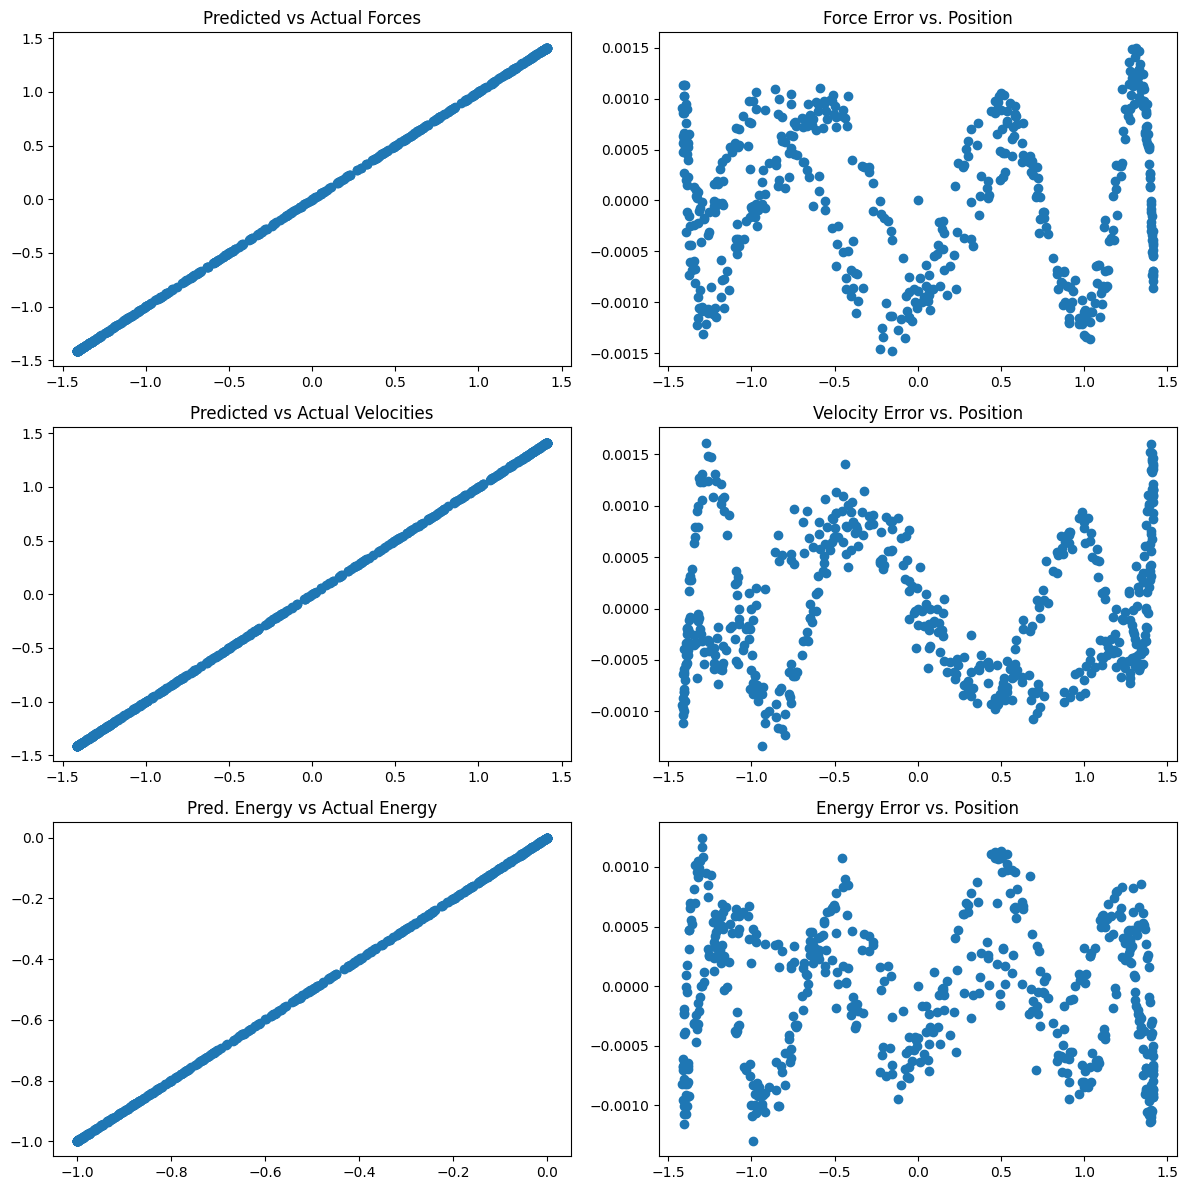

In [9]:
# Visualize predictions

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from hfm.backbones.mlp import MLPBackbone
from hfm.utils import kinetic_energy
import numpy as np
import pickle

i = np.random.randint(0, 1000)
rng = jax.random.PRNGKey(i)

with open("params_ho.pkl", "rb") as f:
    params = pickle.load(f)

model_kwargs = {
    'predict_grad_pot': False,
    'dropout_rate': 0.0,
}
model = MLPBackbone(**model_kwargs)

batch_size = 512
for batch in dataset.next_epoch(rng, batch_size=batch_size):
    positions = batch.nodes["x"]
    forces = batch.nodes["f"]
    p = batch.nodes["p"]
    v = batch.nodes["v"]
    E = batch.globals["Epot"].reshape(-1)
    t = jnp.zeros((positions.shape[0], 1))

    v_pred, f_pred, E_pred = model.apply(params, t, batch, deterministic=True)
    print(f"Predicted forces shape: {f_pred.shape}, Predicted velocities shape: {v_pred.shape}")

    plt.figure(figsize=(12, 12))

    plt.subplot(3, 2, 1)
    plt.scatter(forces, f_pred)
    plt.title("Predicted vs Actual Forces")

    plt.subplot(3, 2, 2)
    print(forces.shape, f_pred.shape)
    plt.title("Force Error vs. Position")
    plt.scatter(positions, forces.reshape(-1) - f_pred.reshape(-1))
    
    plt.subplot(3, 2, 3)
    plt.scatter(v, v_pred)
    plt.title("Predicted vs Actual Velocities")
    
    plt.subplot(3, 2, 4)
    plt.title("Velocity Error vs. Position")
    plt.scatter(positions, v.reshape(-1) - v_pred.reshape(-1))

    plt.subplot(3, 2, 5)
    plt.title("Pred. Energy vs Actual Energy")
    print("here we are", E.shape, E_pred.shape)
    plt.scatter(E.reshape(-1), E_pred.reshape(-1))

    plt.subplot(3, 2, 6)
    plt.title("Energy Error vs. Position")
    plt.scatter(positions, E.reshape(-1) - E_pred.reshape(-1))

    break

plt.tight_layout()

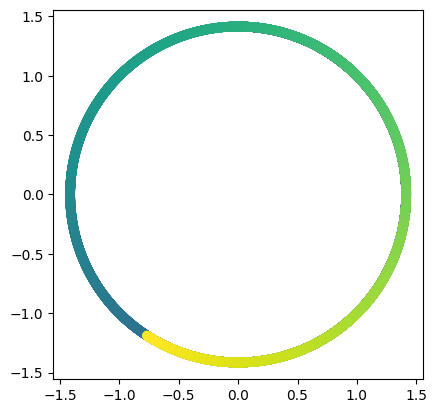

In [10]:
# run simulation with the learned force field
# this means evaluating the hfm with t=0

from hfm.potentials.neural_force_field import NeuralForceField
from hfm.potentials.toy_potentials import HarmonicPotential
from hfm.simulation.nve_integrator import VelocityVerletIntegrator
from hfm.utils import maxwell_boltzmann_distribution
import jax
import jax.numpy as jnp
from hfm.backbones.mlp import MLPBackbone
import pickle
import matplotlib.pyplot as plt

rng_mom, rng_sim = jax.random.split(jax.random.PRNGKey(100))
T = jnp.array([10000.0]).reshape(1, 1)

with open("params_ho.pkl", "rb") as f:
    params = pickle.load(f)

model_kwargs = {
    'predict_grad_pot': False,
    'dropout_rate': 0.0,
}
model = MLPBackbone(**model_kwargs)

ff = NeuralForceField(
    model=model,
    params=params,
    masses=HarmonicPotential().masses,
    atomic_numbers=jnp.zeros_like(HarmonicPotential().masses)
)

integrator = VelocityVerletIntegrator(ff, integration_timestep=1e-3)
start_pos = jnp.array([0.0]).reshape(1, 1, 1)
start_mom = jnp.sqrt(jnp.array([2.0])).reshape(1, 1, 1)
xs, ps, vs, fs = integrator(start_pos, start_mom, 10.0, rng_sim, squeeze_batchdim=True)

plt.scatter(xs.flatten(), ps.flatten(), c=jnp.arange(xs.shape[0]), cmap='viridis')
plt.gca().set_aspect('equal', adjustable='box')

[1.96013258 2.02823571 2.01324269 1.94674853 1.94477565 1.97714231
 1.96458231 2.020395   2.00948526 1.95051118 1.93529702 1.97322943
 1.96817381 1.98557504 1.99922535 1.96656187 1.940536   1.96890165
 1.96552537 1.94713234 2.0025174  1.99025845 1.94616943 1.96174598
 1.97057099 1.9430631  2.01937269 2.00936885 1.94572496 1.94624944
 1.97653595 1.9623068  2.0224414  2.01060899 1.94920917 1.9355085
 1.97392097 1.96855353 1.99152183 2.0002126  1.96379522 1.93945327
 1.96942948 1.96551144 1.95077707 2.00092307 1.98698808 1.94584126
 1.96322969 1.96953151 1.9414134  2.0171766  2.00765964 1.94583697
 1.94850435 1.97618705 1.95994203 2.02392185 2.01154126 1.94814061
 1.93604365 1.9746084  1.96875988 1.99725924 2.00143578 1.96119695
 1.93840606 1.96994241 1.96566453 1.95507152 1.99966349 1.98368331
 1.94536139 1.96452139 1.96855314 1.9403404  2.01481007 2.00561717
 1.94599686 1.95079341 1.975652   1.95731815 2.02472557 2.01218067
 1.94728191 1.9368962  1.97525123 1.96872238 2.00266522 2.00283

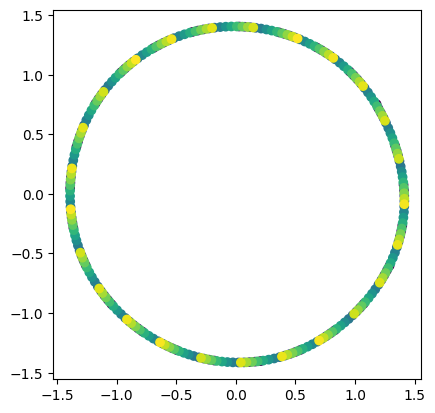

In [11]:
# Now run the mean flow integrator with a larger time step

from hfm.simulation.mean_flow_integrator import HFMIntegrator

rng = jax.random.PRNGKey(42)
mf_integrator = HFMIntegrator(integration_timestep=1.0,
                                model=model,
                                params=params,
                                masses=HarmonicPotential().masses,
                                atomic_numbers=jnp.array([1]).reshape(1, 1, 1))

xs, ps, vs, fs = mf_integrator(start_pos, start_mom, 300.0, rng, squeeze_batchdim=True)
r_squared = (xs**2 + ps**2).reshape(-1)
print(r_squared)

plt.scatter(xs.flatten(), ps.flatten(), c=jnp.arange(xs.shape[0]), cmap='viridis')
plt.gca().set_aspect('equal', adjustable='box')

[[[ 1.4138715 ]]

 [[ 1.3352865 ]]

 [[ 1.0987333 ]]

 [[ 0.7411416 ]]

 [[ 0.3622693 ]]

 [[ 0.08091591]]

 [[-0.15371145]]

 [[-0.3031126 ]]

 [[-0.28115636]]

 [[-0.21130514]]] [[[ 9.5769716e-04]]

 [[-4.1326490e-01]]

 [[-7.4926209e-01]]

 [[-9.7499084e-01]]

 [[-1.0203887e+00]]

 [[-8.9808458e-01]]

 [[-7.0898426e-01]]

 [[-4.6598023e-01]]

 [[-2.7748618e-01]]

 [[-7.3653474e-02]]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1.4142135 1.4142135 1.4142135 1.4142135 1.4142135 1.4142135 1.4142135
 1.4142135 1.4142135 1.4142135] [ 0.          0.80117196  1.31848     1.334055    0.8694464   0.24274772
 -0.55336124 -1.273073   -1.3495506  -1.1410478 ] [ 1.4142135   1.1662546   0.515099   -0.34077    -1.0347196  -1.2800401
 -1.1381298  -0.54290354  0.0822798   1.0164847 ]


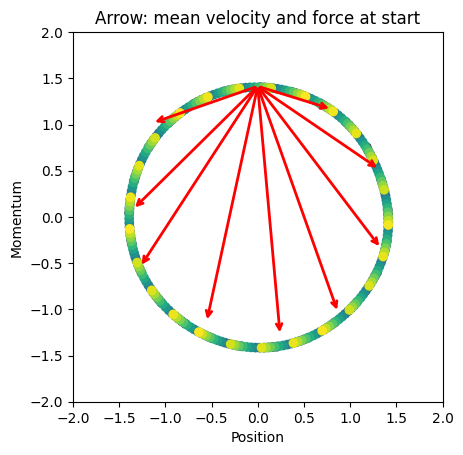

In [12]:
# here we show the average transformation u for different time steps

from hfm.simulation.mean_flow_integrator import HFMIntegrator


mf_integrator = HFMIntegrator(integration_timestep=0.5,
                                model=model,
                                params=params,
                                masses=HarmonicPotential().masses,
                                atomic_numbers=jnp.array([1]).reshape(1, 1, 1))

n = 10
tmax = 6.0

pos_i = jnp.repeat(start_pos, n, axis=0)
mom_i = jnp.repeat(start_mom, n, axis=0)
dt = jnp.arange(0, tmax, step=tmax / n).reshape(-1, 1)

mean_v, mean_f, _ = mf_integrator.apply_f(
            dt,
            pos_i, 
            mom_i, 
            mf_integrator.atomic_numbers,
            mf_integrator.masses)

print(mean_v, mean_f)

startx = pos_i.reshape(-1)
starty = mom_i.reshape(-1)
endx = (pos_i+mean_v*dt.reshape(-1, 1, 1)).reshape(-1)
endy = (mom_i+mean_f*dt.reshape(-1, 1, 1)).reshape(-1)

print(startx, starty, endx, endy)

for i in range(n):
    plt.annotate(
        "", 
        xy=(endx[i].item(), endy[i].item()),        # end point
        xytext=(startx[i].item(), starty[i].item()),    # start point
        arrowprops=dict(arrowstyle="->", color="red", lw=2)
    )

plt.xlabel("Position")
plt.ylabel("Momentum")
plt.title("Arrow: mean velocity and force at start")
plt.scatter(xs.flatten(), ps.flatten(), c=jnp.arange(xs.shape[0]), cmap='viridis')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.gca().set_aspect('equal', adjustable='box')